# Setting

## Environmental Setting

In [1]:
# Anal Env.
import pandas as pd
import numpy  as np
import os
import re
import datetime
import pytz
import copy
from collections import Counter
from emoji       import UNICODE_EMOJI
from functools   import reduce
import operator
import time


import sys
sys.path.append('/home/handeully/')
# GCP Env.
import bigquery_etl as bq


# NLP Env.
import nltk
from nltk import FreqDist
from nltk.corpus   import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem     import WordNetLemmatizer,PorterStemmer,LancasterStemmer
from nltk.corpus   import wordnet
from nltk.corpus   import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag


# stop_words = stopwords.words('english')
import spacy
import gensim
from gensim import corpora
import ray
import psutil
from tqdm.notebook import tqdm


#glove
from glove import Corpus, Glove


# Vis Env.
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Coding Env.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Multi-Core related... 
# #initialization ray
# import ray
# ray.init(ignore_reinit_error=True,num_cpus=5)

import collections

# Model Env.
# model save
import pickle
import joblib
# tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import * # SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# SGD Classification
from sklearn.linear_model import SGDClassifier
# Train-Test Split
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, multilabel_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, mean_squared_error
import itertools
from sklearn.preprocessing import OneHotEncoder
# Earliy-Stopping
from keras.callbacks import EarlyStopping
# modle-plot
# from keras.utils import plot_model

# confusion matrix visualization
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
from sklearn.metrics import classification_report, plot_confusion_matrix,confusion_matrix,accuracy_score

## Define Function

In [2]:
# Load Data FROM Big Query(db connection)
def convert_lowercase(df):
    df_1 =  df.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
    return df_1


#check multiprocessing progress 
def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])


# !!!! @@@@@@@@@ TEAMS Check First @@@@@@@@@ !!!! 
# def ray_multiprocessing_progress(ray_df):
#     for x in tqdm(to_iterator(ray_df), total=len(ray_df)):
#         pass
#     ray_df  = pd.concat(ray.get(ray_df))
#     return ray_df


# pre-processing for review text
def preprocess_review(rvw):
    # Remove punctuations and numbers
    review = re.sub('[^a-zA-Z]', ' ', rvw)
    # Single character removal
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
    # Removing multiple spaces
    review = re.sub(r'\s+', ' ', review)
    return review

def preprocess_stpwds(rvw, stop_words) : 
    rs = []
    for r in rvw.split(" ") : 
        if (r not in stop_words) and (len(r) > 0) : rs.append(r)
    return " ".join(rs)


# Multi-Label Model, Threshold
def calculate_optimal_threshold(y_true, y_pred_cls):
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_cls)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([-0.025, 1.025])
    plt.ylim([-0.025, 1.025])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RoC Curve')
    print("AUC: ", roc_auc)
    
    # Calculate the optimal threshold
    i = np.arange(len(tpr)) # index for df
    roc_df = pd.DataFrame({'threshold' : pd.Series(thresholds, index = i), 
                           'fpr': pd.Series(fpr, index=i), 
                           '1-fpr' : pd.Series(1-fpr, index = i), 
                           'tpr': pd.Series(tpr, index = i), 
                           'diff': pd.Series(tpr - (1-fpr), index = i) })
    opt_threshold = roc_df.iloc[roc_df['diff'].abs().argsort()[:1]]
    print(opt_threshold)
    
    return opt_threshold['threshold'].values[0]

# Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
    	cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    	plt.text(j, i, round(cm[i, j], 2), fontsize=10, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#imports
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[20,20]):
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][col]
#     print(f'tot all:{tot_all}')
#     print(f'cell val:{cell_val}')
    per = round((float(cell_val) / tot_all) * 100,1)
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(tot_all != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_ok = round(per_ok,1)
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.1f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.1f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.1f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.1f', fz=14,
      lw=0.5, cbar=False, figsize=[15,15], show_null_values=0, pred_val_axis='y',title = 'Confusion matrix'):
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 15)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); 
        col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlbl, fontsize=15)
    ax.set_ylabel(ylbl, fontsize=15)
    plt.tight_layout()  #set layout slim
    plt.show()
    fig.savefig('210629_confusion_matrix.jpg')
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.1f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    
    from sklearn.metrics import confusion_matrix
    from datetime import date

    today = date.today()
    # dd/mm/YY
    d1 = today.strftime("%Y%m%d")

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 13;
    figsize=[20,20];
    show_null_values = 2
    df_cm = pd.DataFrame(confm, index=columns, columns=columns)
    title = 'Confusion Matrix(%s)'%(str(d1))
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis,title = title)
#

def _execute_confusion_matrix(y_test,y_pred):
    y_test = y_test
    predic = y_pred

    columns = target_name
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.5
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    fz = 12;
    figsize = [15,15];
    if(len(y_test) > 10):
        fz=9; figsize=[20,20];
    plot_confusion_matrix_from_data(y_test, predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

<br>
====================================================================================
<br>

# Data Load, EDA, Pre-processing

## Shinning Review Data Load

In [4]:
# get shining review data from DB
sql = '''
    SELECT *
    FROM taxonomy.shng_rvw
'''
org_shn_df = bq.select_query(sql)
org_shn_df.shape

(2702, 13)

In [5]:
shn_df = org_shn_df.copy()

# set 'rv' columns for temp key-value
for i in reversed(range(len(shn_df))) : 
    shn_df.loc[i, 'rv'] = 'shng'+str( shn_df[(shn_df['rv']==shn_df.loc[i].rv) & (shn_df['reviews']==shn_df.loc[i].reviews)].index[0] )


# # Multi-label
shn_df.loc[(shn_df['complimenting_factor']=='Design'), 'class'] = 1
shn_df.loc[(shn_df['complimenting_factor']=='Value'), 'class'] = 2
shn_df.loc[(shn_df['complimenting_factor']=='Assemble'), 'class'] = 3
shn_df.loc[(shn_df['complimenting_factor']=='Packaging'), 'class'] = 4
shn_df.loc[(shn_df['complimenting_factor']=='Quality'), 'class'] = 5
shn_df.loc[(shn_df['complimenting_factor']=='Customer service'), 'class'] = 6
shn_df.loc[(shn_df['complimenting_factor']=='Delivery'), 'class'] = 7
shn_df.loc[(shn_df['complimenting_factor']=='Brand Comparison'), 'class'] = 8
shn_df.loc[(shn_df['complimenting_factor']=='Promised customer'), 'class'] = 9
shn_df.loc[(shn_df['complimenting_factor'].str.contains('Others', na=False)), 'class'] = 10
shn_df.loc[(shn_df['complimenting_factor']=='Shining Review'), 'class'] = 10 # not specified factor, but shinning, anyway
shn_df.loc[(shn_df['complimenting_factor'].isnull()), 'class'] = 10 # null values, but shinning

# # Rename Columns
shn_df.rename(columns = {"rv": "reviewId", "new_ctgr": "new_category", "reviews": "review_text"}, inplace=True)

print(shn_df.shape)
shn_df = shn_df.drop_duplicates()
print(shn_df.shape)
print(len(shn_df['reviewId'].unique()))

shn_df.head()

(2702, 14)
(2699, 14)
1211


,date,by,reviewId,category,sku,product_description,rating,title,review_text,complimenting_factors,ref,complimenting_factor,new_category,class
0,201905,Sophie,shng0,Others,PS-C2824C,"3-Step Easy Pet Stairs, Grey, X- Large",5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,"Design, Quality",None,Design,Others,1.0
1,201905,Sophie,shng0,Others,PS-C2824C,"3-Step Easy Pet Stairs, Grey, X- Large",5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,"Design, Quality",None,Quality,Others,5.0
2,201905,Jennie,shng2,Others,PS-C2824C,"3-Step Easy Pet Stairs, Grey, X- Large",5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,"Design, Quality",Jennie) Shining Review? - Marshmallow Mountain...,Design,Others,1.0
3,201905,Jennie,shng2,Others,PS-C2824C,"3-Step Easy Pet Stairs, Grey, X- Large",5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,"Design, Quality",Jennie) Shining Review? - Marshmallow Mountain...,Quality,Others,5.0
4,201904,Jennie,shng4,Others,PS-D2115S,"Pet Stairs Small, Sand",5,Excellent Quality and Price,My chihuahua really loves these steps. He has ...,"Value, Quality",None,Value,Others,2.0


## All Review(2019) Data Load

In [6]:
# get all review data of 2019 from DB
sql2 = '''
    SELECT
        A.*,
        B.prdct_ctgry_4_5 as category,
    FROM
        taxonomy.amz_rvw_all_2019 A
        LEFT JOIN meta.crwl_amz_pdt_mst_all B
        ON A.asin = B.asin
    WHERE 1=1
        AND B.brand = 'Zinus'
        AND A.rating BETWEEN 4 and 5
'''

org_rvw_df = bq.select_query(sql2)

In [7]:
rvw_df = org_rvw_df.copy()

print("Original Review Count :", len(rvw_df))
rvw_df = rvw_df.drop_duplicates()
print("Drop-duplicates Review Count :", len(rvw_df))
rvw_df = rvw_df.sample(n=300)
print("Sample Review Count :", len(rvw_df))

# multi-label
rvw_df['class'] = 0

rvw_df.head()

Original Review Count : 91349
Drop-duplicates Review Count : 91349
Sample Review Count : 300


,reviewId,asin,date,rating,title,review_text,category,brand,category_1,class
15740,R19I8NBXF9FJ8K,B078TSRSMS,2019-01-21 12:00:00,4,Good! Soft wood though,Great but dents and scratches a little easier...,Others,Zinus,Others,0
34438,R3UG6TQR022JX4,B0142WKA10,2019-08-11 12:00:00,5,Haven’t used yet,As advertized,Bed Frames,Zinus,Bed Frames,0
52524,R3DZFHJK8L1Y0J,B00NPVCOSC,2019-04-01 09:00:00+00,5,Excellent,Excellent and high quality. Great purchase. C...,Box Springs,Zinus,Box Springs,0
62410,R2NK8LQ6T3HMZC,B01MZ443I0,2019-01-14 12:00:00,5,Love it. Great for storage under bed.,Love it. Great for storage under bed.,Beds,Zinus,Beds,0
44821,RXGAAW7OPJMFI,B00Q7EPFT4,2019-05-20 12:00:00,5,Can't find a better mattress for the price,We actually slept on this mattress at an AirB...,Mattresses,Zinus,Mattresses,0


## Data Join

In [9]:
shn_df = shn_df[['reviewId', 'new_category', 'rating', 'title', 'review_text', 'class']]
shn_df.rename(columns = {"new_category": "category"}, inplace=True)

In [10]:
rvw_df = rvw_df[['reviewId','category', 'rating', 'title', 'review_text', 'asin','class']]

In [11]:
all_df = pd.concat([shn_df, rvw_df], ignore_index=True)
all_df['class'] = all_df['class'].astype(int)
print(all_df.shape)
all_df.head()

(2999, 7)


,reviewId,category,rating,title,review_text,class,asin
0,shng0,Others,5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,1,NaN
1,shng0,Others,5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,5,NaN
2,shng2,Others,5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,1,NaN
3,shng2,Others,5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,5,NaN
4,shng4,Others,5,Excellent Quality and Price,My chihuahua really loves these steps. He has ...,2,NaN


## Feature Engineering

In [13]:
class_cnt = len(all_df['class'].unique())
class_cnt

11

### set DF for Multi-Label Model

In [14]:
tmp_all_df = pd.concat([all_df, pd.get_dummies(all_df['class'])], axis=1)
tmp_all_df = tmp_all_df.groupby('reviewId').agg({0:'max', 1:'max', 2:'max', 3:'max', 4:'max', 5:'max', 6:'max', 7:'max', 8:'max', 9:'max', 10:'max'})
tmp_all_df.rename(columns = {0:"class_0", 1:"class_1", 2:"class_2", 3:"class_3", 4:"class_4", 5:"class_5", 6:"class_6", 7:"class_7", 8:"class_8", 9:"class_9", 10:"class_10"}, inplace=True)

new_all_df = pd.merge(all_df, tmp_all_df, how='inner', on='reviewId')
new_all_df = new_all_df.drop(['class'], axis=1)
new_all_df = new_all_df.drop_duplicates(ignore_index=True)
new_all_df.head()

,reviewId,category,rating,title,review_text,asin,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10
0,shng0,Others,5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,NaN,0,1,0,0,0,1,0,0,0,0,0
1,shng2,Others,5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,NaN,0,1,0,0,0,1,0,0,0,0,0
2,shng4,Others,5,Excellent Quality and Price,My chihuahua really loves these steps. He has ...,NaN,0,0,1,0,0,1,0,0,0,0,0
3,shng6,Others,5,Great product and great company!,EXACTLY what I was looking for. Good quality a...,NaN,0,0,0,0,0,1,1,0,0,0,1
4,shng12,Others,5,Great Packaging,"Came with all the Necessary Hardware, and a ra...",NaN,0,0,0,0,0,0,0,0,0,1,1


In [15]:
class_label = new_all_df[['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10']]

class_label.head()

,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10
0,0,1,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,1


In [16]:
print(tmp_all_df.class_0.unique())
print(tmp_all_df.class_1.unique())
print(tmp_all_df.class_2.unique())
print(tmp_all_df.class_3.unique())
print(tmp_all_df.class_4.unique())
print(tmp_all_df.class_5.unique())
print(tmp_all_df.class_6.unique())
print(tmp_all_df.class_7.unique())
print(tmp_all_df.class_8.unique())
print(tmp_all_df.class_9.unique())
print(tmp_all_df.class_10.unique())

[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


## EDA

### Data Count by Class

    class  count
0       0    300
1       1    200
2       2    201
3       3    580
4       4    176
5       5    602
6       6     16
7       7     31
8       8    222
9       9    188
10     10    483


<AxesSubplot:>

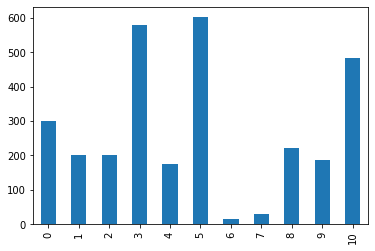

In [20]:
print(all_df.groupby('class').size().reset_index(name='count'))

all_df['class'].value_counts().sort_index().plot(kind='bar')

### Length of Review_Text

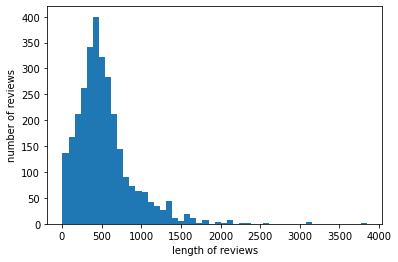

AVG Length : 531.4041347115706


In [23]:
plt.hist([len(r) for r in all_df['review_text']], bins=50)
plt.xlabel('length of reviews')
plt.ylabel('number of reviews')
plt.show()

# Average Length of Reviews
total_len = sum(map(len, all_df['review_text']))
cnt_rvw = len(all_df['review_text'])
print("AVG Length : {}".format(total_len/cnt_rvw))

<br>
====================================================================================
<br>

# Pre-processing

## Set DataFrame for Multi-Label

In [472]:
# multi-label
all_df_lbl = new_all_df.copy()
all_df_lbl.head()

,reviewId,category,rating,title,review_text,asin,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10
0,shng0,Others,5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,NaN,0,1,0,0,0,1,0,0,0,0,0
1,shng2,Others,5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,NaN,0,1,0,0,0,1,0,0,0,0,0
2,shng4,Others,5,Excellent Quality and Price,My chihuahua really loves these steps. He has ...,NaN,0,0,1,0,0,1,0,0,0,0,0
3,shng6,Others,5,Great product and great company!,EXACTLY what I was looking for. Good quality a...,NaN,0,0,0,0,0,1,1,0,0,0,1
4,shng12,Others,5,Great Packaging,"Came with all the Necessary Hardware, and a ra...",NaN,0,0,0,0,0,0,0,0,0,1,1


In [473]:
# Convert All review to lower-case
all_df_lbl = convert_lowercase(all_df_lbl)

## Cleansing Review Text

In [474]:
all_df_lbl['corpus_list'] = all_df_lbl['review_text'].apply(lambda x : preprocess_review(x))

## Shiny-Word(Single+Multi)

In [475]:
factor_sql = '''
                SELECT *
                FROM `taxonomy.shn_kwd` 
            '''
shiny_factor = bq.select_query(factor_sql)
shiny_factor_list = list( set( shiny_factor['keyword'].tolist() ) )
shiny_express = list(filter(lambda x: len(x.split(' '))>=1 , shiny_factor_list))
shiny_express = [tuple(f.split(' ')) for f in shiny_express]

print('Complimenting Factor : ', shiny_factor.shape)
print('Shiny Express lenth : ', len(shiny_express))

Complimenting Factor :  (297, 2)
Shiny Express lenth :  296


## Stopwords

In [476]:
# Get Stopwords list
filter_sql = '''    
    SELECT
      distinct stopword 
    FROM
      market-analysis-project-91130.taxonomy.stp_wds
    WHERE 1=1
      AND stopword not in ('by', 'to', 'of', 'put', 'together', 'up', 'keep', 'itself', 'very', 'well', 'again', 'others', 'really', 'myself', 'more', 'another', 'nice', 'do', 'done', 'super', 'one', 'no', 'thank');
'''
stopword_df = convert_lowercase(bq.select_query(filter_sql))

# Get words related parts ... except parts things
# part_sql = '''
#     SELECT *
#     FROM market-analysis-project-91130.taxonomy.prt_wds
# '''
# parts_df = convert_lowercase(bq.select_query(part_sql))

stop_words = stopword_df['stopword'].tolist()
print('stop_words :', len(stop_words))

# all_df_lbl['corpus_list'] = all_df_lbl['review_text'].apply(lambda x : preprocess_stpwds(x, stop_words))

stop_words : 524


## Tokenization

In [477]:
N_POS_TAG   = ['CC','CD','DT','EX','FW','LS','PDT','POS','PRP','PRP$','TO','WDT','WP','WRB']
Y_POS_TAG   = ['JJ','JJR','JJS','MD','IN','NN','NNS','NNP','NNPS','RB','RBR','RBS','RP','UH','VB','VBG','VBD','VBN','VBP','VBZ', 'TO', 'DT']

def tokenized_corpus(df):
    corpus = []
    reviewid = []
    global shiny_word
    shiny_word = []
    shiny_tokenizer = nltk.tokenize.MWETokenizer(shiny_express, separator=' ')
    # if you wonder that nltk pos tag
    # nltk.help.upenn_tagset()
    
    for i,v in enumerate(tqdm(df['corpus_list'])):
        try:
            word = []
            reviewid.append(str(df.iloc[i].reviewId)) 
           
            for j in pos_tag(regexp_tokenize(v,"[\w']+")) :
                if (j[1] in Y_POS_TAG ) & (len(j[0])>1)  & (j[0].isascii()):
                    word.append(j[0])
            
            # Shiny Factors
            shiny_tokenizer = nltk.tokenize.MWETokenizer(shiny_express, separator=' ')
            tokenized_string = shiny_tokenizer.tokenize(word)
            
            # Lemmatize
            # tokenized_string = [WordNetLemmatizer().lemmatize(x,pos='v') for x in tokenized_string ]
            for i, x in enumerate(tokenized_string) : 
                if len(x.split(' ')) > 1 : # MWE
                    tmp_x = x.split(' ')
                    tmp_x = [WordNetLemmatizer().lemmatize(y, pos='v') for y in tmp_x ]
                    tokenized_string[i] = " ".join(tmp_x)
                else : # Single
                    tokenized_string[i] = WordNetLemmatizer().lemmatize(x, pos='v')
                    
            # Stop Words
            tokenized_corpus = [s for s in tokenized_string if s not in stop_words]
            
            corpus.append(tokenized_corpus)
            ## corpus.append(" ".join(tokenized_string))
            
            tokenized_shiny = [s for s in tokenized_string if s in shiny_factor_list]
            shiny_word.extend(tokenized_shiny)
        except : 
            pass

    corpus_df = pd.DataFrame({'corpus_list' : corpus,'reviewId' : reviewid})
    
    return corpus_df

In [478]:
print('================ Make Corpus ===============')
corpus_all_df_lbl = tokenized_corpus(all_df_lbl)

print('============================================')
all_df_lbl['corpus_list'] = corpus_all_df_lbl['corpus_list']

================ Make Corpus ===============


  0%|          | 0/2999 [00:00<?, ?it/s]

  0%|          | 0/1511 [00:00<?, ?it/s]

### Keyword Count by Class(Multi-Label)

In [492]:
# Count Shiny Factor Words
shiny_word_dict = collections.Counter(shiny_word)
shiny_factor['count'] = shiny_factor['keyword'].apply(lambda x : shiny_word_dict[x])
shiny_factor.sort_values(by=['count'], ascending=False).head(10)
# print(collections.Counter(shiny_word))

,factor,keyword,count
154,Assemble,put together,285
96,Assemble,ratchet,192
111,Assemble,easy to assemble,174
160,Assemble,easy to put together,145
74,Quality,very sturdy,131
141,Assemble,allen wrench,92
126,Assemble,set up,75
157,Assemble,wrench,63
29,Design,look great,56
79,Quality,high quality,43


### Keyword Count by Class(Multi-Class)

In [93]:
kwd_cnt_all_df = all_df_cls.groupby('class').agg({'corpus_list':'sum'})
kwd_cnt_all_df['corpus_set'] = kwd_cnt_all_df['corpus_list'].apply(lambda x : list(set(x)))
kwd_cnt_all_df['corpus_list_count'] = kwd_cnt_all_df['corpus_list'].apply(lambda x : len(x))
kwd_cnt_all_df['corpus_set_count'] = kwd_cnt_all_df['corpus_set'].apply(lambda x : len(x))
kwd_cnt_all_df

,corpus_list,corpus_set,corpus_list_count,corpus_set_count
class,,,,
0,"[time, to, assemble, sure, plenty, of, space, ...","[pero, slats', worry, longevity, somewhat, ins...",5512,1402
1,"[of, dog, welcome, bed, older, jump, bed, good...","[worry, luggage, inside, reputation, smartbase...",9543,1771
2,"[chihuahua, really, love, step, neck, problem,...","[worry, lucy, inside, reputation, incase, poun...",9938,1850
3,"[look, best, buy, zinus, smartbase, use, toy, ...","[worry, luggage, longevity, cheek, somewhat, a...",28556,2909
4,"[minnie, small, way, to, look, order, medium, ...","[worry, somewhat, areas, inside, reputation, i...",9444,1639
5,"[of, dog, welcome, bed, older, jump, bed, good...","[worry, cheek, funky, families, somewhat, turt...",29367,3186
6,"[exactly, look, good quality, nice appearance,...","[worry, promptly, register, size, secure, clea...",1090,514
7,"[inherit, kinda, nice, couch, bed, mom, mattre...","[worry, size, lack, inside, iit, sofa, secure,...",1622,637
8,"[come, snag, seam, panel, hide, bed, love, hea...","[worry, longevity, funky, areas, inside, smart...",8838,1609


<br>
====================================================================================
<br>

# Model

## Multi-Label

In [196]:
all_df_lbl['corpus_list'] = all_df_lbl['corpus_list'].apply(lambda x : " ".join(x))
all_df_lbl.head()

,reviewId,category,rating,title,review_text,asin,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10,corpus_list
0,shng0,Others,5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,NaN,0,1,0,0,0,1,0,0,0,0,0,First of LB dog welcome bed older jump bed goo...
1,shng2,Others,5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,NaN,0,1,0,0,0,1,0,0,0,0,0,stairs reason dog sleep again help up down bed...
2,shng4,Others,5,Excellent Quality and Price,My chihuahua really loves these steps. He has ...,NaN,0,0,1,0,0,1,0,0,0,0,0,chihuahua really love step neck problem suppos...
3,shng6,Others,5,Great product and great company!,EXACTLY what I was looking for. Good quality a...,NaN,0,0,0,0,0,1,1,0,0,0,1,EXACTLY look Good quality nice appearance comp...
4,shng12,Others,5,Great Packaging,"Came with all the Necessary Hardware, and a ra...",NaN,0,0,0,0,0,0,0,0,0,1,1,Came Necessary Hardware ratchet ease of instal...


### Set Features&Tragets, Train-Test Split

In [197]:
# Using Shiny Factors for Test Data
shn_fct_df = shiny_factor.copy()

shn_fct_df.loc[(shn_fct_df['factor']=='Design'), 'class'] = 1
shn_fct_df.loc[(shn_fct_df['factor']=='Value'), 'class'] = 2
shn_fct_df.loc[(shn_fct_df['factor']=='Assemble'), 'class'] = 3
shn_fct_df.loc[(shn_fct_df['factor']=='Packaging'), 'class'] = 4
shn_fct_df.loc[(shn_fct_df['factor']=='Quality'), 'class'] = 5
shn_fct_df.loc[(shn_fct_df['factor']=='Customer Service'), 'class'] = 6
shn_fct_df.loc[(shn_fct_df['factor']=='Delivery'), 'class'] = 7
shn_fct_df.loc[(shn_fct_df['factor']=='Brand Comparison'), 'class'] = 8
shn_fct_df.loc[(shn_fct_df['factor']=='Promised Customer'), 'class'] = 9
shn_fct_df.loc[(shn_fct_df['factor']=='Others'), 'class'] = 10

shn_fct_df['class_0'] = 0
shn_fct_df = pd.concat([shn_fct_df, pd.get_dummies(shn_fct_df['class'])], axis=1)
shn_fct_df.rename(columns = {0:"class_0", 1:"class_1", 2:"class_2", 3:"class_3", 4:"class_4", 5:"class_5", 6:"class_6", 7:"class_7", 8:"class_8", 9:"class_9", 10:"class_10"}, inplace=True)

print(shn_fct_df.shape)
shn_fct_df.head()

(285, 15)


,factor,keyword,count,class,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10
0,Quality,no creaking,0,5.0,0,0,0,0,0,1,0,0,0,0,0
1,Value,worth the price,0,2.0,0,0,1,0,0,0,0,0,0,0,0
2,Value,beat the price,0,2.0,0,0,1,0,0,0,0,0,0,0,0
3,Value,for the price,0,2.0,0,0,1,0,0,0,0,0,0,0,0
4,Value,cheaper than,7,2.0,0,0,1,0,0,0,0,0,0,0,0


In [198]:
# 종속변수
tmp_x = pd.concat([all_df_lbl['corpus_list'], shn_fct_df['keyword']], ignore_index=True)
# 독립변수
tmp_y = pd.concat([class_label, shn_fct_df.iloc[:, 4:]], ignore_index=True)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tmp_x)
sequences = tokenizer.texts_to_sequences(tmp_x)
# sequences[:5]
vocab_size = len(tokenizer.word_index) + 1

# train-test split
max_len = 1000
tmp_x = pad_sequences(sequences, maxlen=max_len)
x_train, x_test, y_train, y_test = train_test_split(tmp_x, tmp_y, test_size=0.2)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1436, 1000)
(1436, 11)
(360, 1000)
(360, 11)


### LSTM

In [199]:
# Stack LSTM Model Layer
model3 = Sequential()
model3.add(Input(shape=(max_len,)))
model3.add(Embedding(vocab_size, 128))
model3.add(LSTM(128, return_sequences=True))
model3.add(SpatialDropout1D(0.2))
model3.add(LSTM(64))
model3.add(Dense(class_cnt, activation='sigmoid'))

# ealry stop condition
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# fit
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model3.summary())
history3 = model3.fit(x_train, y_train, epochs=100, callbacks=[es], batch_size=32 , verbose=1, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 128)         602368    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 128)         131584    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                715       
Total params: 784,075
Trainable params: 784,075
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
36/36 [==============================] - 51s 1s/step - loss: 0.4683 - accuracy: 0.1585 - val_loss

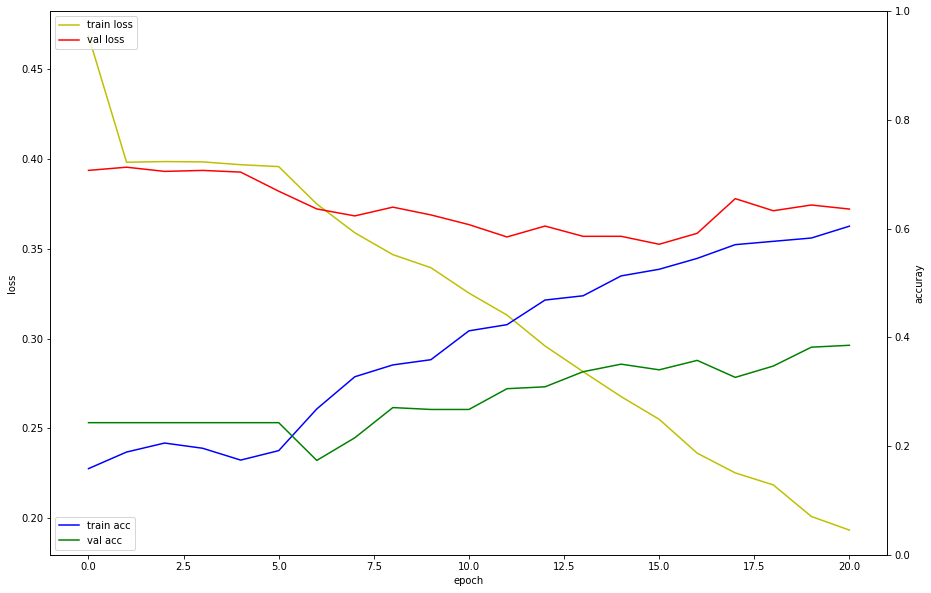

In [200]:
# fig = plt.figure(figsize=(15, 6)) 
fig, loss_ax = plt.subplots(figsize=(15, 10))
acc_ax = loss_ax.twinx()
plt.ylim(0, 1)

loss_ax.plot(history3.history['loss'], 'y', label='train loss')
loss_ax.plot(history3.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history3.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history3.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
acc_ax.set_ylabel('accuray')
acc_ax.legend(loc='lower left')

plt.show()

### Calculate Threshold

[0.01801601,
 0.1092149,
 0.07055578,
 0.34727803,
 0.12792066,
 0.30199885,
 0.013949722,
 0.030455261,
 0.044971734,
 0.09054336,
 0.36378938]

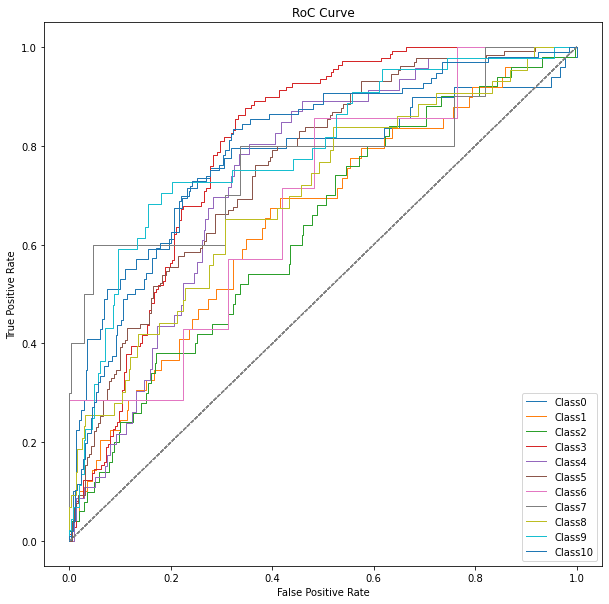

In [201]:
# Predict the values from the validation dataset
y_pred = model3.predict(x_test)
y_true = np.asarray(y_test)

# ROC
threshold = [0] * class_cnt
line_color = ['', ]
plt.figure(figsize=(10, 10))
    
for i in range(class_cnt) : 
    # ROC Accuarcy
    fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    # print(i, " === ", roc_auc)
    
    # Plot ROC Curve
    plt.plot(fpr, tpr, lw=1, label='Class'+str(i))
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RoC Curve')
    plt.legend(loc='lower right')
    
    # Calculate Optimal Threshold
    l = np.arange(len(tpr)) # index for df
    roc_df = pd.DataFrame({'threshold' : pd.Series(thresholds, index=l), 
                           'fpr': pd.Series(fpr, index=l), 
                           '1-fpr' : pd.Series(1-fpr, index=l), 
                           'tpr': pd.Series(tpr, index=l), 
                           'diff': pd.Series(tpr - (1-fpr), index=l)
                          })

    threshold[i] = roc_df.iloc[roc_df['diff'].abs().argsort()[:1]]['threshold'].values[0]

threshold

### Predict

In [202]:
# Predict the values from the validation dataset
y_pred = model3.predict(x_test)
print("=====================")
print("y_pred's shape =", y_pred.shape)

# Convert predictions classes to one hot vectors
y_pred_class = []
for i in range(len(x_test)) : 
    if y_pred[i].argmax() == 0 : # Non-Shiny Review
        y_pred_class.append(np.array([1] + [0]*(class_cnt-1)))
    else : 
        y_pred_class.append(1*(y_pred[i] > 0.5))
        if 1 in y_pred_class[i][1:] : 
            y_pred_class[i][0] = 0
        else :  
            y_pred_class[i][0] = 1
    
print("=====================")
print("y_pred_classes's shape =", np.shape(y_pred_class))

# Convert validation observations to one hot vectors
y_true = np.asarray(y_test)
print("=====================")
print("y_true's shape =", y_true.shape)

# compute confusion matrix and print confusion report
confusion_mtx = multilabel_confusion_matrix(y_true, y_pred_class)
print("=====================")
print(confusion_mtx)

# Score
print("=====================")
score = model3.evaluate(x_test, y_test)
print ("Test Loss = " + str(score[0]))
print ("Test Accuracy = " + str(score[1]))

label_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10']
# label_names = ['class_0', 'class_1', 'class_2', 'class_3']
print("=====================")
print(classification_report(y_true, y_pred_class, target_names=label_names))

y_pred's shape = (360, 11)
y_pred_classes's shape = (360, 11)
y_true's shape = (360, 11)
[[[235  76]
  [ 13  36]]

 [[311   0]
  [ 49   0]]

 [[310   0]
  [ 49   1]]

 [[177  46]
  [ 53  84]]

 [[297  17]
  [ 40   6]]

 [[181  49]
  [ 58  72]]

 [[353   0]
  [  7   0]]

 [[350   0]
  [ 10   0]]

 [[308   9]
  [ 34   9]]

 [[309   7]
  [ 39   5]]

 [[210  54]
  [ 36  60]]]
12/12 [==============================] - 5s 368ms/step - loss: 0.3850 - accuracy: 0.3306
Test Loss = 0.38500091433525085
Test Accuracy = 0.3305555582046509
              precision    recall  f1-score   support

     class_0       0.32      0.73      0.45        49
     class_1       0.00      0.00      0.00        49
     class_2       1.00      0.02      0.04        50
     class_3       0.65      0.61      0.63       137
     class_4       0.26      0.13      0.17        46
     class_5       0.60      0.55      0.57       130
     class_6       0.00      0.00      0.00         7
     class_7       0.00      0.00   

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [203]:
# Predict the values from the validation dataset
y_pred = model3.predict(x_test)
print("=====================")
print("y_pred's shape =", y_pred.shape)

# Convert predictions classes to one hot vectors
ROCthreshold_y_pred_class = []
for i in range(len(x_test)) : 
    if y_pred[i].argmax() == 0 : # Non-Shiny Review
        ROCthreshold_y_pred_class.append(np.array([1] + [0]*(class_cnt-1)))
    else : 
        ROCthreshold_y_pred_class.append(1*(y_pred[i] > threshold))
        if 1 in ROCthreshold_y_pred_class[i][1:] : 
            ROCthreshold_y_pred_class[i][0] = 0
        else :  
            ROCthreshold_y_pred_class[i][0] = 1
    
print("=====================")
print("y_pred_classes's shape =", np.shape(ROCthreshold_y_pred_class))

# Convert validation observations to one hot vectors
y_true = np.asarray(y_test)
print("=====================")
print("y_true's shape =", y_true.shape)

# compute confusion matrix and print confusion report
confusion_mtx = multilabel_confusion_matrix(y_true, ROCthreshold_y_pred_class)
print("=====================")
print(confusion_mtx)

# Score
print("=====================")
score = model3.evaluate(x_test, y_test)
print ("Test Loss = " + str(score[0]))
print ("Test Accuracy = " + str(score[1]))

label_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10']
# label_names = ['class_0', 'class_1', 'class_2', 'class_3']
print("=====================")
print(classification_report(y_true, ROCthreshold_y_pred_class, target_names=label_names))

y_pred's shape = (360, 11)
y_pred_classes's shape = (360, 11)
y_true's shape = (360, 11)
[[[286  25]
  [ 25  24]]

 [[194 117]
  [ 19  30]]

 [[176 134]
  [ 22  28]]

 [[162  61]
  [ 39  98]]

 [[217  97]
  [ 14  32]]

 [[156  74]
  [ 43  87]]

 [[224 129]
  [  4   3]]

 [[259  91]
  [  6   4]]

 [[228  89]
  [ 20  23]]

 [[217  99]
  [ 12  32]]

 [[194  70]
  [ 26  70]]]
12/12 [==============================] - 5s 376ms/step - loss: 0.3850 - accuracy: 0.3306
Test Loss = 0.38500091433525085
Test Accuracy = 0.3305555582046509
              precision    recall  f1-score   support

     class_0       0.49      0.49      0.49        49
     class_1       0.20      0.61      0.31        49
     class_2       0.17      0.56      0.26        50
     class_3       0.62      0.72      0.66       137
     class_4       0.25      0.70      0.37        46
     class_5       0.54      0.67      0.60       130
     class_6       0.02      0.43      0.04         7
     class_7       0.04      0.40   

### Confusion Matrix

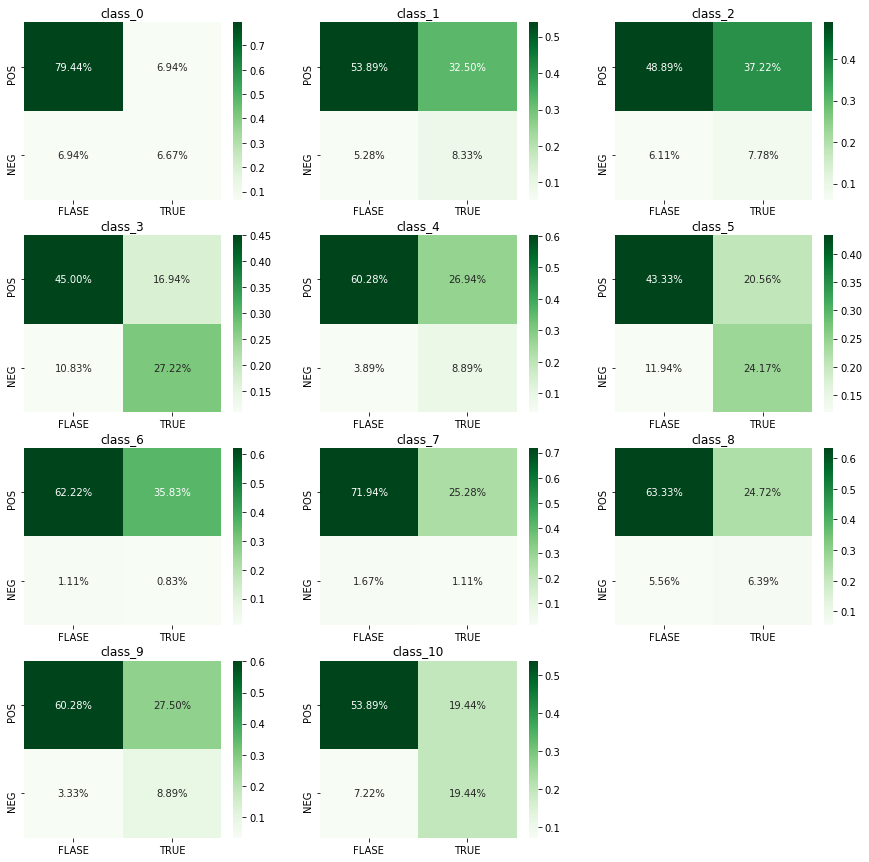

In [204]:
# plot confusion matrix
fig = plt.figure(figsize=(15, 15))
num_of_quality = 11
# num_of_quality = 4

# cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens

for i in range(len(confusion_mtx)) : 
    ax = fig.add_subplot(4, 3, i+1)
#     ax = fig.add_subplot(2, 2, i+1)
    cls_name = 'class_'+str(i)
    ax.set_title(cls_name)
    plt.xlabel('TRUE/FLASE')
    plt.ylabel('POS/NEG')
    
    cm = confusion_mtx[i]
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Greens', xticklabels=['FLASE', 'TRUE'], yticklabels=['POS', 'NEG'])
    plt.subplots_adjust()

<br>
====================================================================================
<br>

# Validation

## Multi-Label, LSTM

In [212]:
# Load Data
test_df = all_df_lbl.copy()
# Tokenizing Data
test_all_rvw = test_df['corpus_list']
# tokenizer.fit_on_texts(test_all_rvw)
test_all_rvw = tokenizer.texts_to_sequences(test_all_rvw)
test_all_rvw = pad_sequences(sequences, maxlen=max_len)

In [213]:
# predict
test_all_pred = model3.predict(test_all_rvw)
# threshold - 1
test_pred_class = 1*(test_all_pred > 0.5)
# threshold - 2
test_roc_pred_class = []
for i in range(len(test_df)) : 
    if test_all_pred[i].argmax() == 0 : # Non-Shiny Review
        test_roc_pred_class.append(np.array([1] + [0]*(class_cnt-1)))
    else : 
        test_roc_pred_class.append(1*(test_all_pred[i] > threshold))
        if 1 in test_roc_pred_class[i][1:] : 
            test_roc_pred_class[i][0] = 0
        else :  
            test_roc_pred_class[i][0] = 1

In [214]:
# concat the result dataframe - using threshold 1
test_pred_df = pd.DataFrame(test_pred_class, columns=['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9', 'pred_10'])
rs_mtl_lbl = pd.concat([test_df, test_pred_df[:len(all_df_lbl)]], axis=1)

# caculate accuracy
for i in range(class_cnt) : 
    cls_n = 'class_' + str(i)
    pred_n = 'pred_' + str(i)
    a = len(rs_mtl_lbl[rs_mtl_lbl[cls_n]==1])
    b = rs_mtl_lbl[rs_mtl_lbl[cls_n]==1][pred_n].sum()
    print("{} : {:.2f} \t {}/{}".format(i, b/a, b, a))

y_true = np.array(rs_mtl_lbl[['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10']])
y_pred = np.array(rs_mtl_lbl[['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9', 'pred_10']])

print(classification_report(y_true, y_pred))
accuracy_score(y_true,y_pred)

0 : 0.78 	 234/300
1 : 0.03 	 5/196
2 : 0.05 	 9/199
3 : 0.83 	 471/568
4 : 0.31 	 53/169
5 : 0.75 	 439/589
6 : 0.00 	 0/15
7 : 0.00 	 0/31
8 : 0.44 	 96/219
9 : 0.29 	 53/183
10 : 0.85 	 357/418
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       300
           1       0.71      0.03      0.05       196
           2       0.60      0.05      0.08       199
           3       0.78      0.83      0.80       568
           4       0.45      0.31      0.37       169
           5       0.75      0.75      0.75       589
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        31
           8       0.86      0.44      0.58       219
           9       0.75      0.29      0.42       183
          10       0.68      0.85      0.76       418

   micro avg       0.75      0.59      0.66      2887
   macro avg       0.59      0.39      0.42      2887
weighted avg       0.73      0.59      0.61  

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39642620780939775

In [215]:
# concat the result dataframe - using threshold 2
test_pred_df = pd.DataFrame(test_roc_pred_class, columns=['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9', 'pred_10'])
rs_mtl_lbl = pd.concat([test_df, test_pred_df[:len(all_df_lbl)]], axis=1)

# caculate accuracy
for i in range(class_cnt) : 
    cls_n = 'class_' + str(i)
    pred_n = 'pred_' + str(i)
    a = len(rs_mtl_lbl[rs_mtl_lbl[cls_n]==1])
    b = rs_mtl_lbl[rs_mtl_lbl[cls_n]==1][pred_n].sum()
    print("{} : {:.2f} \t {}/{}".format(i, b/a, b, a))
    
y_true = np.array(rs_mtl_lbl[['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10']])
y_pred = np.array(rs_mtl_lbl[['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9', 'pred_10']])

print(classification_report(y_true, y_pred))
accuracy_score(y_true,y_pred)

0 : 0.84 	 252/300
1 : 0.78 	 152/196
2 : 0.86 	 171/199
3 : 0.90 	 510/568
4 : 0.85 	 144/169
5 : 0.85 	 502/589
6 : 0.60 	 9/15
7 : 0.42 	 13/31
8 : 0.81 	 177/219
9 : 0.87 	 159/183
10 : 0.90 	 376/418
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       300
           1       0.23      0.78      0.35       196
           2       0.22      0.86      0.35       199
           3       0.72      0.90      0.80       568
           4       0.26      0.85      0.40       169
           5       0.68      0.85      0.75       589
           6       0.02      0.60      0.03        15
           7       0.04      0.42      0.07        31
           8       0.31      0.81      0.45       219
           9       0.28      0.87      0.42       183
          10       0.62      0.90      0.74       418

   micro avg       0.39      0.85      0.54      2887
   macro avg       0.39      0.79      0.48      2887
weighted avg       0.55      0.85    

0.18266048974189278

<br>
====================================================================================
<br>